In [1]:
import csv
import glob
import json
import os

import librosa as rosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import soundfile as sf
import tensorflow as tf
from IPython.display import Audio, display
from pandas.api.types import CategoricalDtype
from pydub import AudioSegment
from pysndfx import AudioEffectsChain
from tensorflow.python.ops import gen_audio_ops
from tqdm.notebook import tqdm

print(tf.__version__)

2.13.0-rc2


In [2]:
DEBUG = True

TARGET_WORD = "komputer"

SAMPLE_RATE = 16000

FRAME_LENGTH = 320
FRAME_STEP = 160
POOLING_SIZE = [1, 6]

VOICE_THRESHOLD = 0.25
VOICE_STEPS_PER_SECOND = 100
VOICE_STEPS = SAMPLE_RATE // VOICE_STEPS_PER_SECOND

NEW_TRAINING_FILES_PER_AUDIO = 10

DATA_PATH = "data"

MODEL_PATH = os.path.join(DATA_PATH, "model.tflite")
MODEL_BEFORE_RESEARCH_PATH = os.path.join(DATA_PATH, "model_before_research.tflite")
MODEL_AFTER_RESEARCH_PATH = os.path.join(DATA_PATH, "model_after_research.tflite")
MODEL_FINAL_PATH = os.path.join(DATA_PATH, "model_final.tflite")

RECORDINGS_PATH = os.path.join(DATA_PATH, "recordings")
NEW_RECORDINGS_PATH = os.path.join(DATA_PATH, "new_recordings")
ALL_RECORDINGS_PATH = os.path.join(DATA_PATH, "all_recordings")

TRAINING_PATH = os.path.join(DATA_PATH, "training")

os.makedirs(TRAINING_PATH, exist_ok=True)

sns.set(style="whitegrid")
pd.set_option('display.max_rows', 40)

In [3]:
def create_model(model_path):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    return {
        "interpreter": interpreter,
        "input_details": input_details,
        "output_details": output_details,
    }

In [4]:
def plot_audio(audio):
    _, axe = plt.subplots(figsize=(8, 6))
    axe.plot(audio)
    axe.set_title("Audio wave")
    axe.set_xlabel("Time")
    axe.set_ylabel("Amplitude")
    plt.show()
    display(Audio(audio, rate=16000))


def plot_spectrogram(spec):
    spec = np.squeeze(spec)
    spec = np.rot90(spec, 3)
    _, axe = plt.subplots(figsize=(8, 6))
    axe.imshow(spec, aspect="auto", origin="lower", cmap="jet")
    axe.set_title("Spectrogram")
    axe.set_xlabel("Time")
    axe.set_ylabel("Frequency")
    plt.show()

In [5]:
def get_voice(audio):
    audio = normalize_audio(audio)
    abs_audio = np.abs(audio)
    segment_sum = [
        np.sum(abs_audio[s : s + SAMPLE_RATE])
        for s in range(0, len(abs_audio), VOICE_STEPS)
    ]
    row_sum = [np.sum(segment_sum[i : i + 10]) for i in range(0, len(segment_sum))]
    first_segment = np.argmax(row_sum) * VOICE_STEPS
    return cure_audio(audio[first_segment : first_segment + SAMPLE_RATE])


def get_background_noise_level(participant_path):
    audio = AudioSegment.from_wav(os.path.join(participant_path, "noise_0.wav"))
    return audio.max_dBFS


def normalize_audio(audio):
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    return audio


def cut_audio_length(audio, length=SAMPLE_RATE):
    audio_len = len(audio)
    if audio_len < length:
        audio = np.append(audio, np.zeros(length - audio_len))
    audio = audio[:length]
    return audio


def cure_audio(audio):
    audio = cut_audio_length(audio)
    audio = normalize_audio(audio)
    return tf.cast(audio, tf.float32)


def get_spectrogram(audio):
    spec = gen_audio_ops.audio_spectrogram(
        tf.expand_dims(audio, -1),
        window_size=FRAME_LENGTH,
        stride=FRAME_STEP,
        magnitude_squared=True,
    )
    spec = tf.expand_dims(spec, -1)
    spec = tf.nn.pool(
        input=spec,
        window_shape=POOLING_SIZE,
        strides=POOLING_SIZE,
        pooling_type="AVG",
        padding="SAME",
    )
    spec = np.squeeze(spec, axis=0)
    spec = np.log10(spec + 1e-6)
    return spec

In [6]:
def augment_audio(x):
    fx = AudioEffectsChain()
    fn = ""

    if np.random.random() < 0.3:
        fx = fx.highshelf()
        fn += "_hs"

    if np.random.random() < 0.5:
        fx = fx.reverb(
            np.random.randint(0, 50),
            np.random.randint(0, 50),
            np.random.randint(0, 100),
        )
        fn += "_rvb"

    if np.random.random() < 0.8:
        fx = fx.pitch(np.random.randint(-200, 200))
        fn += "_pc"

    if np.random.random() < 0.3:
        fx = fx.phaser()
        fn += "_ph"

    if np.random.random() < 0.3:
        fx = fx.lowshelf()
        fn += "_ls"

    return fx(tf.reshape(x, -1).numpy())[:16000], fn

In [7]:
def run_interpreter(audio, model):
    interpreter = model["interpreter"]
    input_details = model["input_details"]
    output_details = model["output_details"]

    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, 0)
    interpreter.set_tensor(input_details[0]["index"], spectrogram)
    interpreter.invoke()

    output_data = np.argmax(interpreter.get_tensor(output_details[0]["index"])[0])

    return 1 if output_data == 0 else 0

In [13]:
def get_participant_info(participant_path):
    with open(os.path.join(participant_path, "participant.json"), "r") as file:
        return json.load(file)


def get_training_file_path(file_name, new_file_name, participant_id):
    return os.path.join(
        TRAINING_PATH, f"{TARGET_WORD}_{participant_id}_{new_file_name}_{file_name}"
    )


def generate_training_files(audio, file_name, participant_id):
    training_files = [
        (audio, get_training_file_path(file_name, "original", participant_id))
    ]

    for i in range(NEW_TRAINING_FILES_PER_AUDIO):
        new_audio, new_file_name = augment_audio(audio)
        new_audio = normalize_audio(new_audio)
        new_file_name = get_training_file_path(file_name, new_file_name, participant_id)
        training_files.append((new_audio, new_file_name))

    return training_files


def save_training_files(training_files):
    for audio, file_path in training_files:
        sf.write(file_path, audio, SAMPLE_RATE, subtype="PCM_16")


def generate_participant_data(
    participant_id, participant_info, distance, noise_level, detected
):
    return {
        "ID": participant_id,
        "Płeć": participant_info["gender"],
        "Wiek": participant_info["age"],
        "Odległość": distance,
        "Szum tła (dB)": noise_level,
        "Wynik": detected,
    }


def save_participant_data(participant_path, participant_data):
    keys = participant_data[0].keys()
    csv_filename = os.path.join(participant_path, "results.csv")
    with open(csv_filename, "w", newline="") as output_file:
        dict_writer = csv.DictWriter(output_file, fieldnames=keys)
        dict_writer.writeheader()
        dict_writer.writerows(participant_data)


def process_participant(participant_path, model):
    participant_id = os.path.basename(os.path.normpath(participant_path))
    participant_info = get_participant_info(participant_path)
    noise_level = get_background_noise_level(participant_path)

    if DEBUG:
        print(f"Processing {participant_id}")
        print(f"Participant info: {participant_info}")
        print(f"Noise level: {noise_level}")

    participant_data = []
    good = 0
    all = 0

    distances = ["50cm", "1m", "3m", "5m"]
    for distance in distances:
        for idx in range(5):
            file_name = f"{distance}_{idx}.wav"
            file_path = os.path.join(participant_path, file_name)

            audio, _ = rosa.load(file_path, sr=SAMPLE_RATE, mono=True)
            audio = get_voice(audio)

            # training_files = generate_training_files(audio, file_name, participant_id)
            # save_training_files(training_files)

            detected = run_interpreter(audio, model)

            good += 1 if detected else 0
            all += 1

            if DEBUG and not detected:
                print(f"Processing {file_path}")
                # plot_audio(audio)

            participant_data.append(
                generate_participant_data(
                    participant_id, participant_info, distance, noise_level, detected
                )
            )

    save_participant_data(participant_path, participant_data)

    if DEBUG:
        print(f"Accuracy for {participant_id}: ", good / all)

    return good, all

In [14]:
def convert_distance(x):
    try:
        if "cm" in x:
            return float(x.replace("cm", "")) / 100
        elif "m" in x:
            return float(x.replace("m", ""))
        else:
            return float(x)
    except ValueError:
        print(x)
        raise ValueError


def combine_results(recordings_path):
    dfs = []
    for file_path in glob.glob(recordings_path + "/*/results.csv"):
        dfs.append(pd.read_csv(file_path))

    combined_df = pd.concat(dfs)

    combined_df["Płeć"] = combined_df["Płeć"].replace(
        {"male": "mężczyzna", "female": "kobieta"}
    )

    age_dict = {
        "below_18": "<18",
        "18_30": "18-30",
        "31_50": "31-50",
        "above_50": "50+",
    }
    combined_df["Wiek"] = combined_df["Wiek"].replace(age_dict)

    dist_dict = {"50cm": 0.5, "1m": 1.0, "3m": 3.0, "5m": 5.0}
    combined_df["Odległość"] = combined_df["Odległość"].replace(dist_dict)

    combined_path = os.path.join(recordings_path, "combined_results.csv")
    combined_df.to_csv(combined_path, index=False)

    if DEBUG:
        print(f"Combined results saved in {combined_path}")


def load_combined_results(recordings_path):
    df = pd.read_csv(os.path.join(recordings_path, "combined_results.csv"))

    cat_type = CategoricalDtype(
        categories=["<18", "18-30", "31-50", "50+"], ordered=True
    )
    df["Wiek"] = df["Wiek"].astype(cat_type)

    display(df)

    return df

In [15]:
def calculate_averages(df, recordings_path):
    recordings_type = os.path.basename(os.path.normpath(recordings_path))

    average_by_gender = df.groupby("Płeć")["Wynik"].mean()
    display(average_by_gender.reset_index())
    fig = plt.figure(figsize=(8, 6))
    sns.barplot(x=average_by_gender.index, y=average_by_gender.values, palette="muted")
    plt.title("Średnie wyniki według płci")
    plt.xlabel("Płeć")
    plt.ylabel("Średni wynik")
    plt.ylim(0, 1)
    plt.show()
    fig.savefig(os.path.join(recordings_path, f"{recordings_type}_gender_mean.png"))

    average_by_age = df.groupby("Wiek")["Wynik"].mean()
    display(average_by_age.reset_index())
    fig = plt.figure(figsize=(8, 6))
    sns.barplot(x=average_by_age.index, y=average_by_age.values, palette="muted")
    plt.title("Średnie wyniki według grupy wiekowej")
    plt.xlabel("Grupa wiekowa")
    plt.ylabel("Średni wynik")
    plt.ylim(0, 1)
    plt.show()
    fig.savefig(os.path.join(recordings_path, f"{recordings_type}_age_mean.png"))

    average_by_distance = df.groupby("Odległość")["Wynik"].mean()
    display(average_by_distance.reset_index())
    fig = plt.figure(figsize=(8, 6))
    sns.barplot(
        x=average_by_distance.index, y=average_by_distance.values, palette="muted"
    )
    plt.title("Średnie wyniki według odległości")
    plt.xlabel("Odległość (m)")
    plt.ylabel("Średni wynik")
    plt.ylim(0, 1)
    plt.show()
    fig.savefig(os.path.join(recordings_path, f"{recordings_type}_distance_mean.png"))


def create_histograms(df, recordings_path):
    recordings_type = os.path.basename(os.path.normpath(recordings_path))

    fig = plt.figure(figsize=(8, 6))
    sns.histplot(df["Płeć"], bins=2, color="skyblue", kde=False)
    plt.title("Histogram płci")
    plt.xlabel("Płeć")
    plt.ylabel("Liczebność")
    plt.show()
    fig.savefig(
        os.path.join(recordings_path, f"{recordings_type}_gender_histogram.png")
    )

    fig = plt.figure(figsize=(8, 6))
    sns.histplot(df["Wiek"], bins=4, color="skyblue", kde=False)
    plt.title("Histogram grupy wiekowej")
    plt.xlabel("Grupa wiekowa")
    plt.ylabel("Liczebność")
    plt.show()
    fig.savefig(os.path.join(recordings_path, f"{recordings_type}_age_histogram.png"))

    fig = plt.figure(figsize=(8, 6))
    sns.histplot(df["Szum tła (dB)"], bins=20, color="skyblue", kde=False)
    plt.title("Histogram szumu tła")
    plt.xlabel("Szum tła (dB)")
    plt.ylabel("Liczebność")
    plt.show()
    fig.savefig(os.path.join(recordings_path, f"{recordings_type}_noise_histogram.png"))


def create_correlation_matrix(df, recordings_path):
    recordings_type = os.path.basename(os.path.normpath(recordings_path))

    df_encoded = df.copy()
    df_encoded["Płeć"] = np.where(df_encoded["Płeć"] == "mężczyzna", 1, 0)
    df_encoded["Wiek"] = df_encoded["Wiek"].map(
        {"<18": 1, "18-30": 2, "30-50": 3, "50+": 4}
    )
    corr_matrix = df_encoded[
        ["Płeć", "Wiek", "Odległość", "Szum tła (dB)", "Wynik"]
    ].corr()
    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True
    )
    plt.title("Macierz korelacji")
    plt.show()
    fig.savefig(
        os.path.join(recordings_path, f"{recordings_type}_correlation_matrix.png")
    )


def create_pivot_table(df, recordings_path):
    recordings_type = os.path.basename(os.path.normpath(recordings_path))

    pivot_table = df.pivot_table(
        values="Wynik", index=["Płeć", "Wiek"], columns="Odległość", aggfunc="mean"
    )
    pivot_table = pivot_table.round(2)
    display(pivot_table)
    fig = plt.figure(figsize=(8, 6))
    sns.heatmap(
        pivot_table, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True
    )
    plt.title("Średnie wyniki według płci i grupy wiekowej")
    plt.show()
    fig.savefig(os.path.join(recordings_path, f"{recordings_type}_pivot_table.png"))

In [16]:
def process_recordings(recordings_path, model):
    participants = [
        d
        for d in os.listdir(recordings_path)
        if os.path.isdir(os.path.join(recordings_path, d))
    ]
    good = 0
    all = 0

    for participant_id in tqdm(participants, desc="Processing participants"):
        if os.path.isdir(os.path.join(recordings_path, participant_id)):
            participant_path = os.path.join(recordings_path, participant_id)
            participant_good, participant_all = process_participant(
                participant_path, model
            )
            good += participant_good
            all += participant_all

    print(f"Accuracy: {good / all}")

    combine_results(recordings_path)
    df = load_combined_results(recordings_path)

    calculate_averages(df, recordings_path)
    create_histograms(df, recordings_path)
    create_correlation_matrix(df, recordings_path)
    create_pivot_table(df, recordings_path)

Procesowanie pierwszej tury badań

Processing participants:   0%|          | 0/28 [00:00<?, ?it/s]

Processing cc5bcef7-4407-4f45-8ace-1d57b0fe8032
Participant info: {'gender': 'female', 'age': '18_30'}
Noise level: -65.70002027162887
Accuracy for cc5bcef7-4407-4f45-8ace-1d57b0fe8032:  1.0
Processing 469fc991-f604-422d-82ac-6ef56b8326a5
Participant info: {'gender': 'female', 'age': 'above_50'}
Noise level: -50.05225420509091
Processing data/recordings/469fc991-f604-422d-82ac-6ef56b8326a5/50cm_0.wav
Processing data/recordings/469fc991-f604-422d-82ac-6ef56b8326a5/50cm_2.wav
Processing data/recordings/469fc991-f604-422d-82ac-6ef56b8326a5/50cm_4.wav
Processing data/recordings/469fc991-f604-422d-82ac-6ef56b8326a5/1m_1.wav
Processing data/recordings/469fc991-f604-422d-82ac-6ef56b8326a5/5m_2.wav
Accuracy for 469fc991-f604-422d-82ac-6ef56b8326a5:  0.75
Processing 9b1d82f2-039d-428a-94c8-a8bc82d9015a
Participant info: {'gender': 'male', 'age': '18_30'}
Noise level: -38.55477939881613
Accuracy for 9b1d82f2-039d-428a-94c8-a8bc82d9015a:  1.0
Processing e735adb3-bb9a-4ddc-b028-1a9c9df96a3a
Partic

,ID,Płeć,Wiek,Odległość,Szum tła (dB),Wynik
0,cc5bcef7-4407-4f45-8ace-1d57b0fe8032,kobieta,18-30,0.5,-65.700020,1
1,cc5bcef7-4407-4f45-8ace-1d57b0fe8032,kobieta,18-30,0.5,-65.700020,1
2,cc5bcef7-4407-4f45-8ace-1d57b0fe8032,kobieta,18-30,0.5,-65.700020,1
3,cc5bcef7-4407-4f45-8ace-1d57b0fe8032,kobieta,18-30,0.5,-65.700020,1
4,cc5bcef7-4407-4f45-8ace-1d57b0fe8032,kobieta,18-30,0.5,-65.700020,1
...,...,...,...,...,...,...
555,f1239580-9f31-432a-972e-e971fe97a049,mężczyzna,31-50,5.0,-58.267799,0
556,f1239580-9f31-432a-972e-e971fe97a049,mężczyzna,31-50,5.0,-58.267799,0
557,f1239580-9f31-432a-972e-e971fe97a049,mężczyzna,31-50,5.0,-58.267799,0
558,f1239580-9f31-432a-972e-e971fe97a049,mężczyzna,31-50,5.0,-58.267799,0


,Płeć,Wynik
0,kobieta,0.872727
1,mężczyzna,0.735294


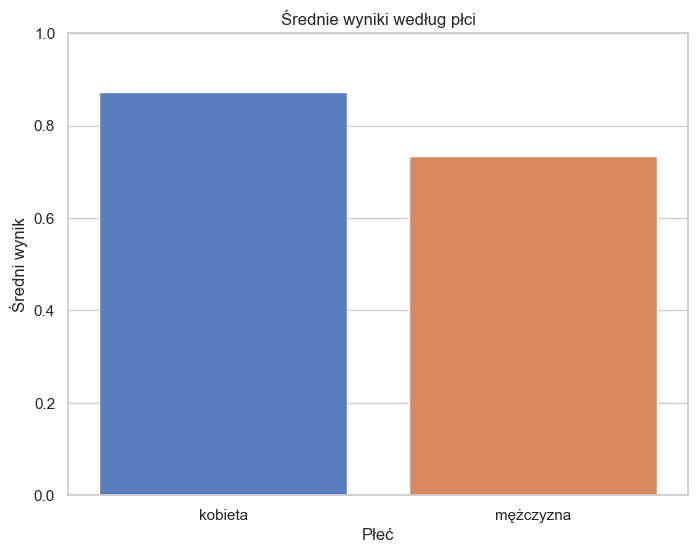

,Wiek,Wynik
0,<18,0.600000
1,18-30,0.900000
2,31-50,0.829167
3,50+,0.562500


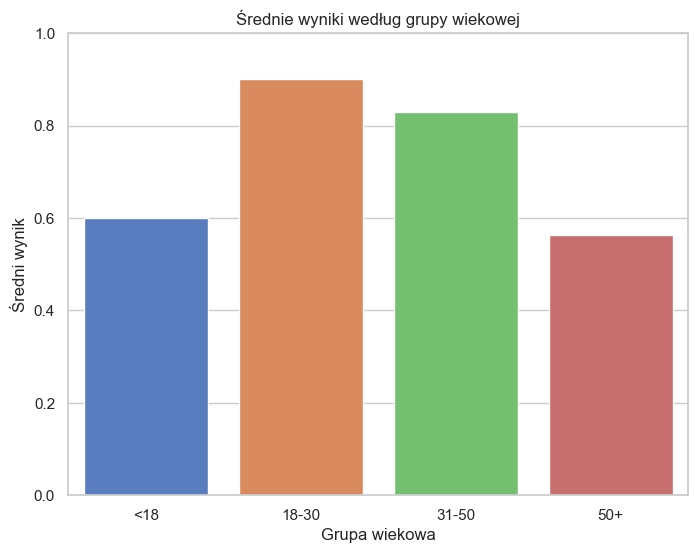

,Odległość,Wynik
0,0.5,0.857143
1,1.0,0.835714
2,3.0,0.757143
3,5.0,0.707143


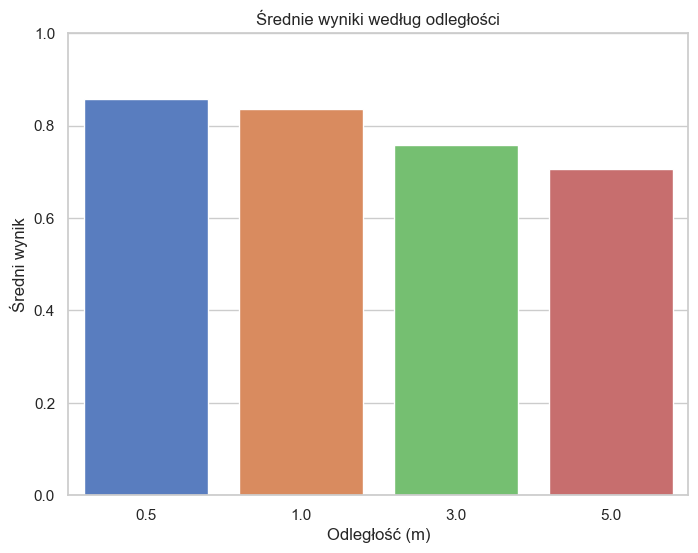

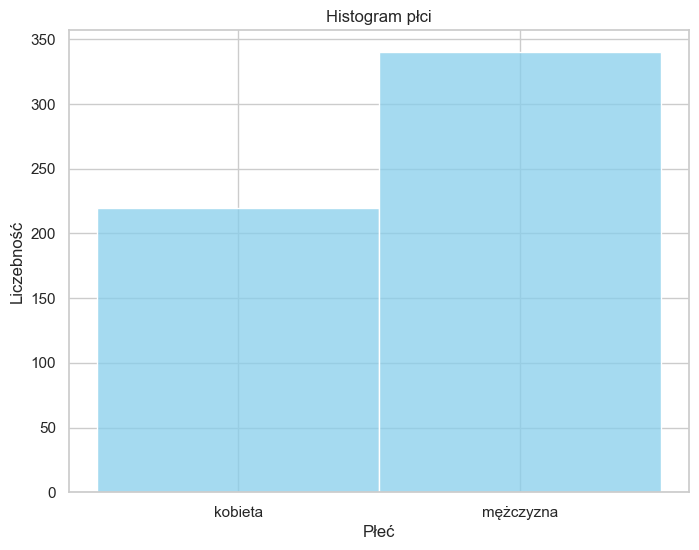

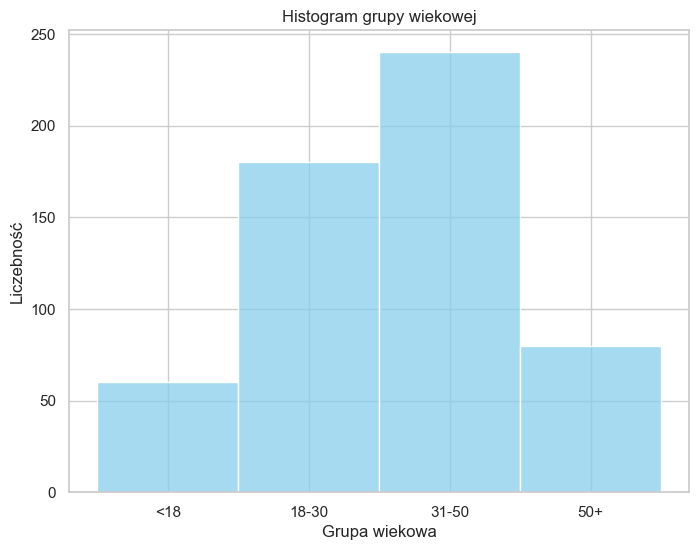

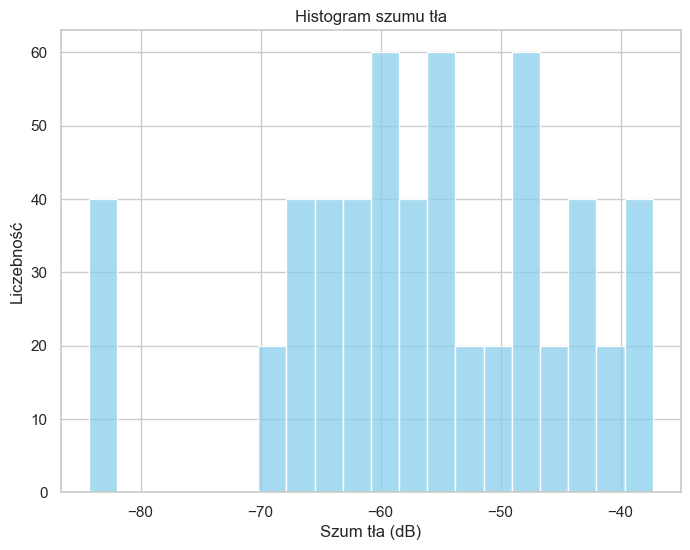

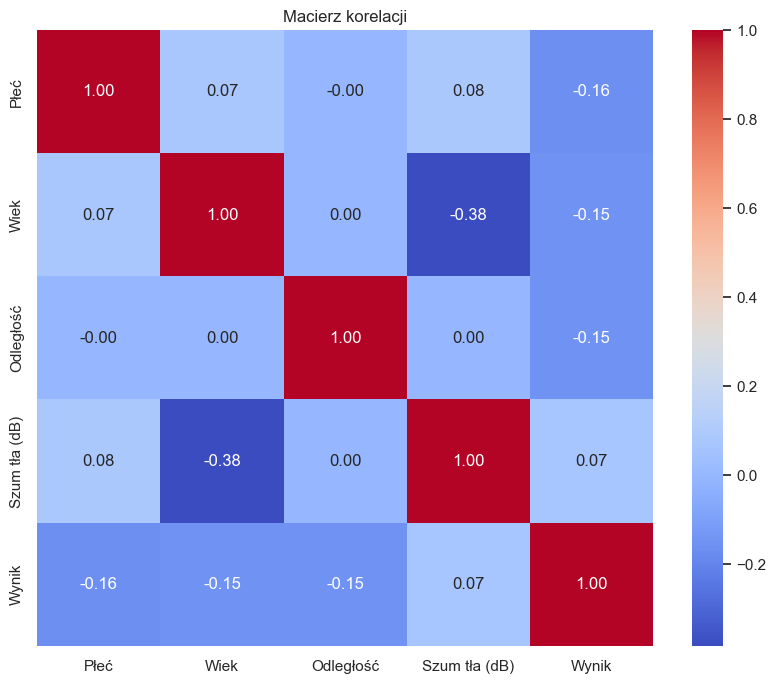

Odległość         0.5   1.0   3.0   5.0
Płeć      Wiek                         
kobieta   <18    0.60  0.40  0.60  0.20
          18-30  1.00  0.87  0.80  0.93
          31-50  0.97  0.93  0.90  1.00
          50+    0.40  0.80  1.00  0.80
mężczyzna <18    0.50  0.90  0.70  0.60
          18-30  0.93  0.90  0.90  0.87
          31-50  0.87  0.80  0.63  0.53
          50+    0.80  0.67  0.40  0.13

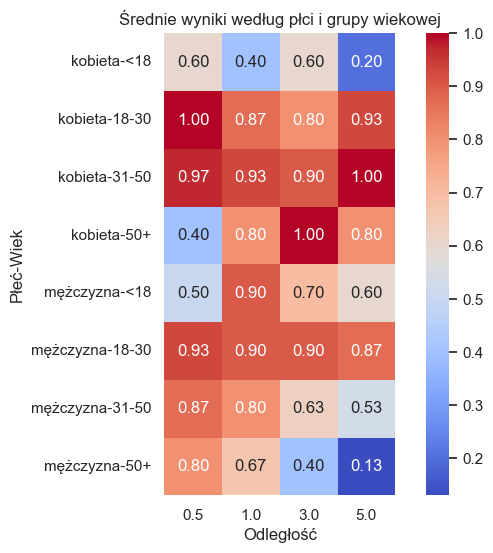

In [47]:
model_before_research = create_model(MODEL_BEFORE_RESEARCH_PATH)
process_recordings(RECORDINGS_PATH, model_before_research)

Procesowanie po wyszkoleniu sieci danymi z pierwszej tury badań

Processing participants:   0%|          | 0/13 [00:00<?, ?it/s]

Processing a5c51501-421d-49e9-9514-29aaa09f9fd1
Participant info: {'gender': 'male', 'age': 'above_50'}
Noise level: -35.97224423320387
Accuracy for a5c51501-421d-49e9-9514-29aaa09f9fd1:  1.0
Processing 907da96d-0d2b-41cf-9f06-5490bb7c207c
Participant info: {'gender': 'female', 'age': 'above_50'}
Noise level: -29.82749895304583
Processing data/new_recordings/907da96d-0d2b-41cf-9f06-5490bb7c207c/3m_3.wav
Processing data/new_recordings/907da96d-0d2b-41cf-9f06-5490bb7c207c/5m_0.wav
Processing data/new_recordings/907da96d-0d2b-41cf-9f06-5490bb7c207c/5m_1.wav
Processing data/new_recordings/907da96d-0d2b-41cf-9f06-5490bb7c207c/5m_2.wav
Processing data/new_recordings/907da96d-0d2b-41cf-9f06-5490bb7c207c/5m_3.wav
Processing data/new_recordings/907da96d-0d2b-41cf-9f06-5490bb7c207c/5m_4.wav
Accuracy for 907da96d-0d2b-41cf-9f06-5490bb7c207c:  0.7
Processing 3d029e84-c595-4271-9463-c6fc2afc8ced
Participant info: {'gender': 'male', 'age': 'above_50'}
Noise level: -30.892766481744005
Accuracy for 3d

,ID,Płeć,Wiek,Odległość,Szum tła (dB),Wynik
0,a5c51501-421d-49e9-9514-29aaa09f9fd1,mężczyzna,50+,0.5,-35.972244,1
1,a5c51501-421d-49e9-9514-29aaa09f9fd1,mężczyzna,50+,0.5,-35.972244,1
2,a5c51501-421d-49e9-9514-29aaa09f9fd1,mężczyzna,50+,0.5,-35.972244,1
3,a5c51501-421d-49e9-9514-29aaa09f9fd1,mężczyzna,50+,0.5,-35.972244,1
4,a5c51501-421d-49e9-9514-29aaa09f9fd1,mężczyzna,50+,0.5,-35.972244,1
...,...,...,...,...,...,...
255,d90647d7-0a99-4bec-8899-4d673dff237a,kobieta,18-30,5.0,-47.638221,0
256,d90647d7-0a99-4bec-8899-4d673dff237a,kobieta,18-30,5.0,-47.638221,1
257,d90647d7-0a99-4bec-8899-4d673dff237a,kobieta,18-30,5.0,-47.638221,1
258,d90647d7-0a99-4bec-8899-4d673dff237a,kobieta,18-30,5.0,-47.638221,0


,Płeć,Wynik
0,kobieta,0.925
1,mężczyzna,1.000


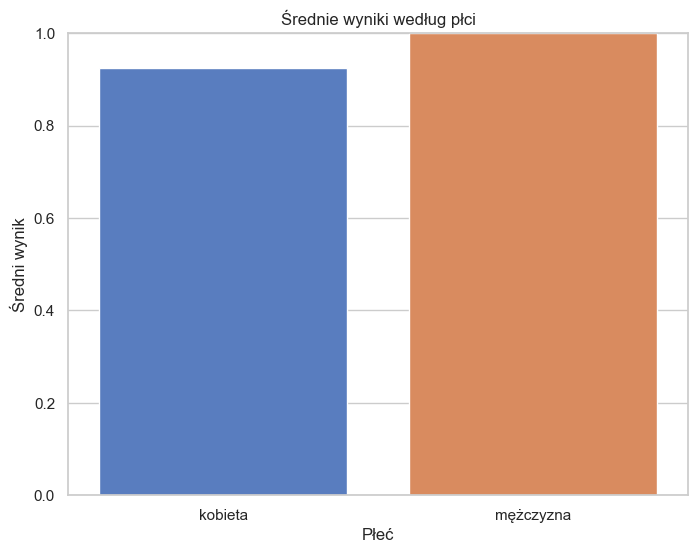

,Wiek,Wynik
0,<18,1.000000
1,18-30,0.964286
2,31-50,0.975000
3,50+,0.900000


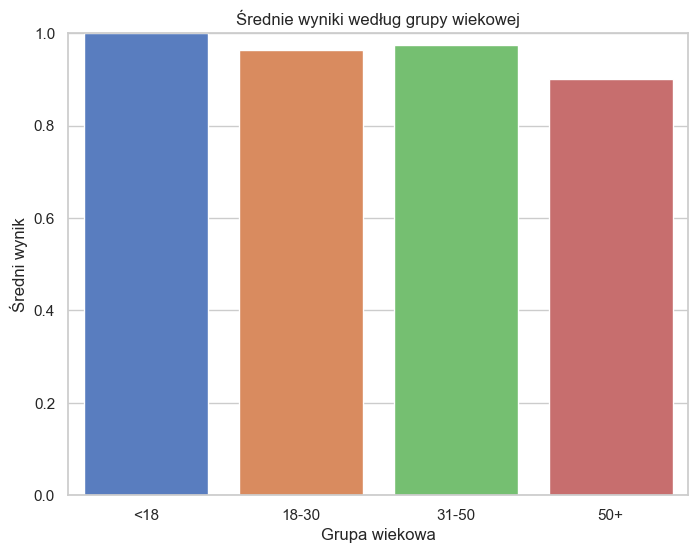

,Odległość,Wynik
0,0.5,0.969231
1,1.0,0.984615
2,3.0,0.984615
3,5.0,0.876923


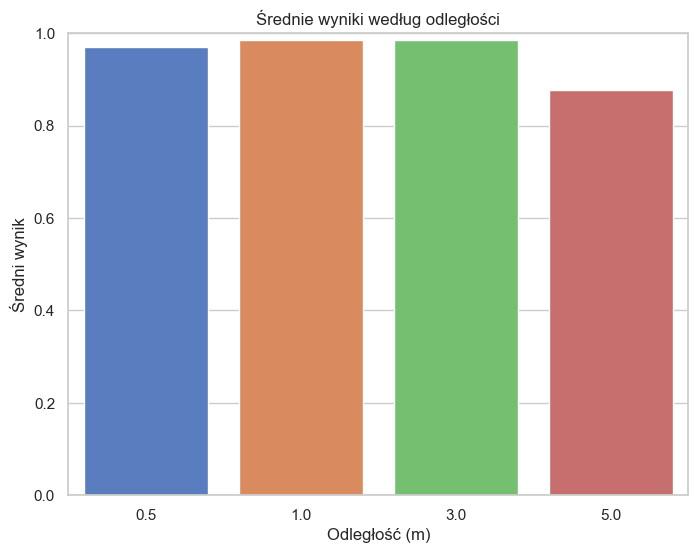

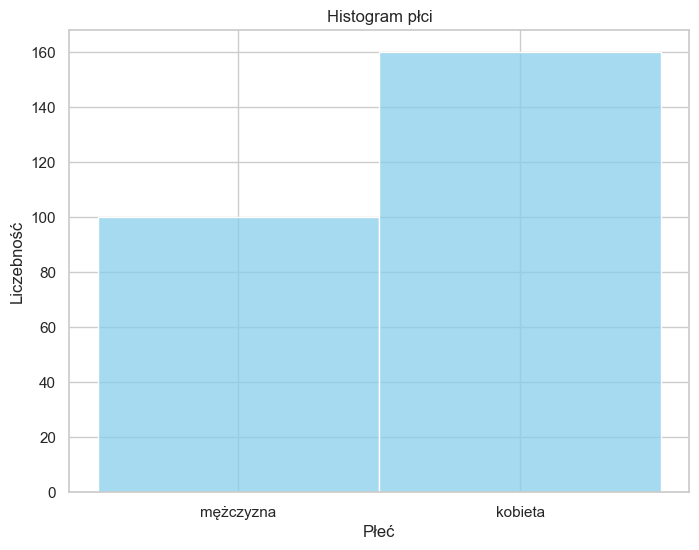

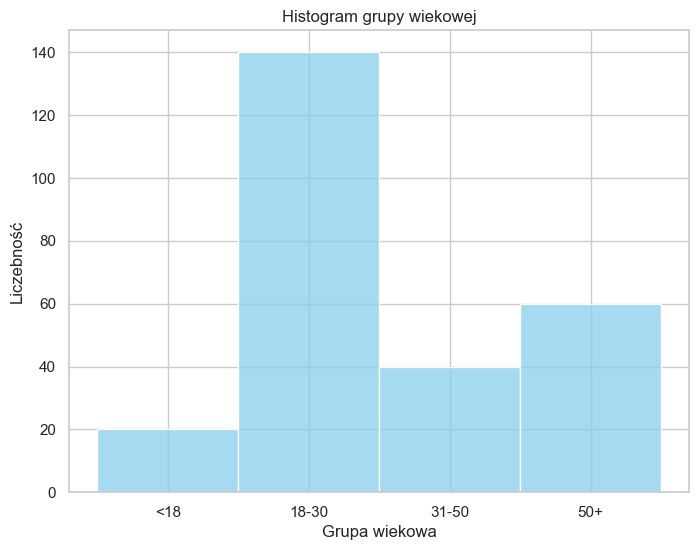

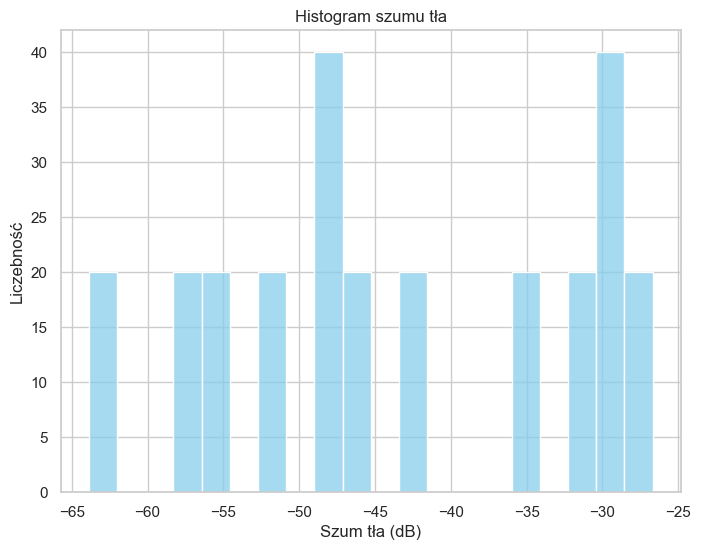

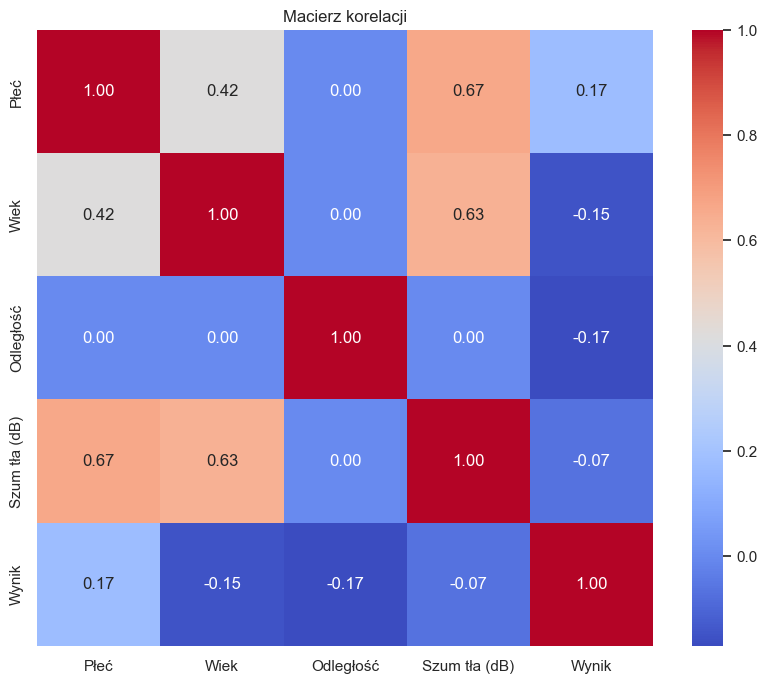

Odległość         0.5   1.0  3.0   5.0
Płeć      Wiek                        
kobieta   <18    1.00  1.00  1.0  1.00
          18-30  0.92  0.96  1.0  0.92
          31-50  1.00  1.00  1.0  0.80
          50+    1.00  1.00  0.8  0.00
mężczyzna 18-30  1.00  1.00  1.0  1.00
          31-50  1.00  1.00  1.0  1.00
          50+    1.00  1.00  1.0  1.00

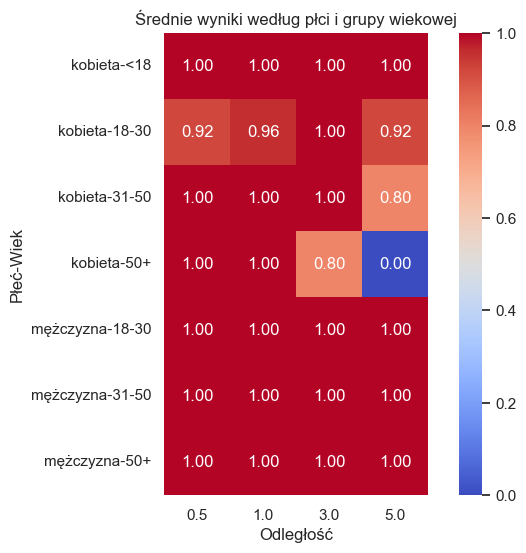

In [14]:
model_after_research = create_model(MODEL_AFTER_RESEARCH_PATH)
process_recordings(NEW_RECORDINGS_PATH, model_after_research)

Procesowanie wszystkich danych po ostatecznym wyszkoleniu sieci

Processing participants:   0%|          | 0/41 [00:00<?, ?it/s]

Processing a5c51501-421d-49e9-9514-29aaa09f9fd1
Participant info: {'gender': 'male', 'age': 'above_50'}
Noise level: -35.97224423320387
Processing data/all_recordings/a5c51501-421d-49e9-9514-29aaa09f9fd1/50cm_0.wav
Processing data/all_recordings/a5c51501-421d-49e9-9514-29aaa09f9fd1/50cm_1.wav
Processing data/all_recordings/a5c51501-421d-49e9-9514-29aaa09f9fd1/50cm_2.wav
Processing data/all_recordings/a5c51501-421d-49e9-9514-29aaa09f9fd1/50cm_3.wav
Processing data/all_recordings/a5c51501-421d-49e9-9514-29aaa09f9fd1/50cm_4.wav
Processing data/all_recordings/a5c51501-421d-49e9-9514-29aaa09f9fd1/1m_0.wav
Processing data/all_recordings/a5c51501-421d-49e9-9514-29aaa09f9fd1/1m_1.wav
Processing data/all_recordings/a5c51501-421d-49e9-9514-29aaa09f9fd1/1m_2.wav
Processing data/all_recordings/a5c51501-421d-49e9-9514-29aaa09f9fd1/1m_3.wav
Processing data/all_recordings/a5c51501-421d-49e9-9514-29aaa09f9fd1/1m_4.wav
Processing data/all_recordings/a5c51501-421d-49e9-9514-29aaa09f9fd1/3m_0.wav
Process

,ID,Płeć,Wiek,Odległość,Szum tła (dB),Wynik
0,a5c51501-421d-49e9-9514-29aaa09f9fd1,mężczyzna,50+,0.5,-35.972244,0
1,a5c51501-421d-49e9-9514-29aaa09f9fd1,mężczyzna,50+,0.5,-35.972244,0
2,a5c51501-421d-49e9-9514-29aaa09f9fd1,mężczyzna,50+,0.5,-35.972244,0
3,a5c51501-421d-49e9-9514-29aaa09f9fd1,mężczyzna,50+,0.5,-35.972244,0
4,a5c51501-421d-49e9-9514-29aaa09f9fd1,mężczyzna,50+,0.5,-35.972244,0
...,...,...,...,...,...,...
815,f1239580-9f31-432a-972e-e971fe97a049,mężczyzna,31-50,5.0,-58.267799,0
816,f1239580-9f31-432a-972e-e971fe97a049,mężczyzna,31-50,5.0,-58.267799,0
817,f1239580-9f31-432a-972e-e971fe97a049,mężczyzna,31-50,5.0,-58.267799,0
818,f1239580-9f31-432a-972e-e971fe97a049,mężczyzna,31-50,5.0,-58.267799,0


,Płeć,Wynik
0,kobieta,0.0
1,mężczyzna,0.0


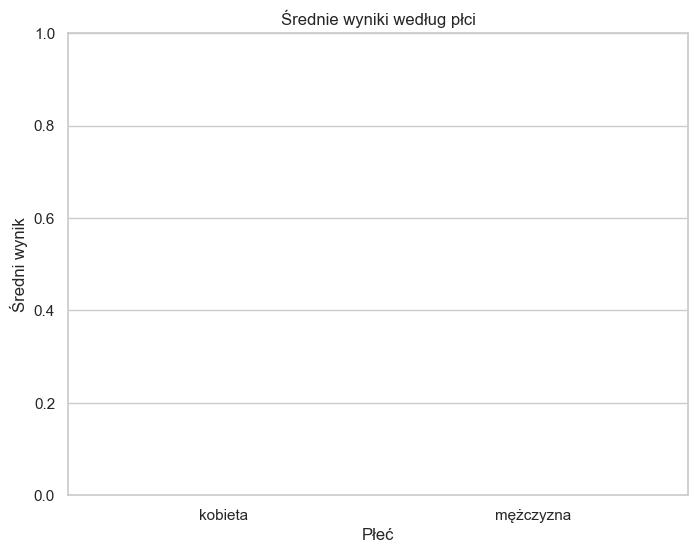

,Wiek,Wynik
0,<18,0.0
1,18-30,0.0
2,31-50,0.0
3,50+,0.0


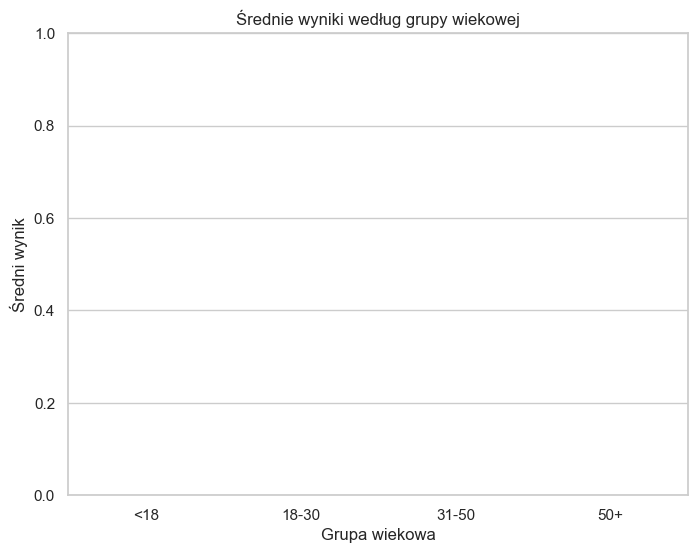

,Odległość,Wynik
0,0.5,0.0
1,1.0,0.0
2,3.0,0.0
3,5.0,0.0


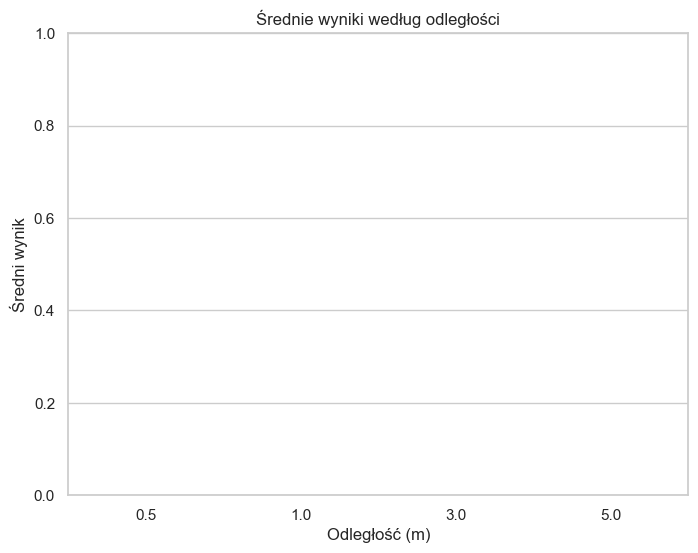

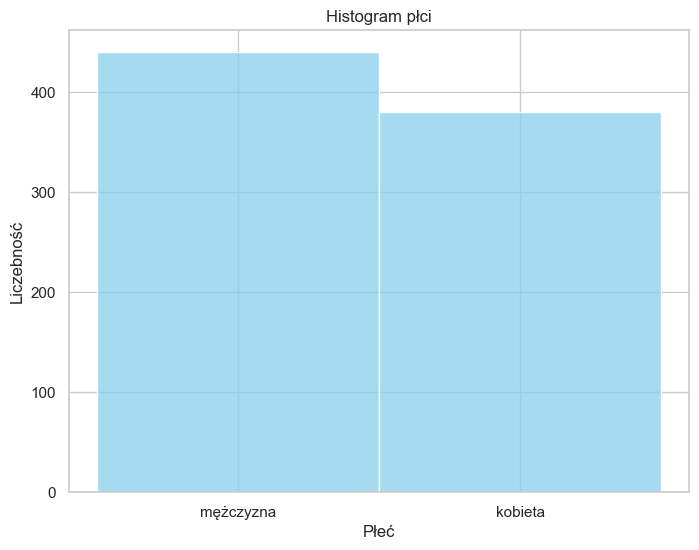

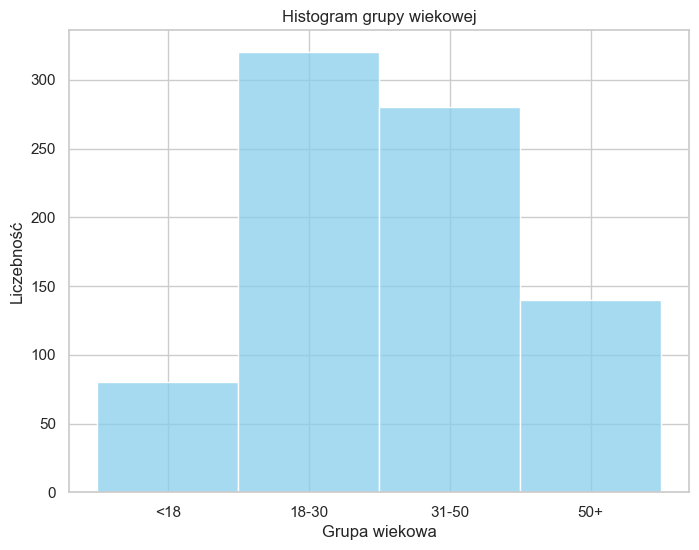

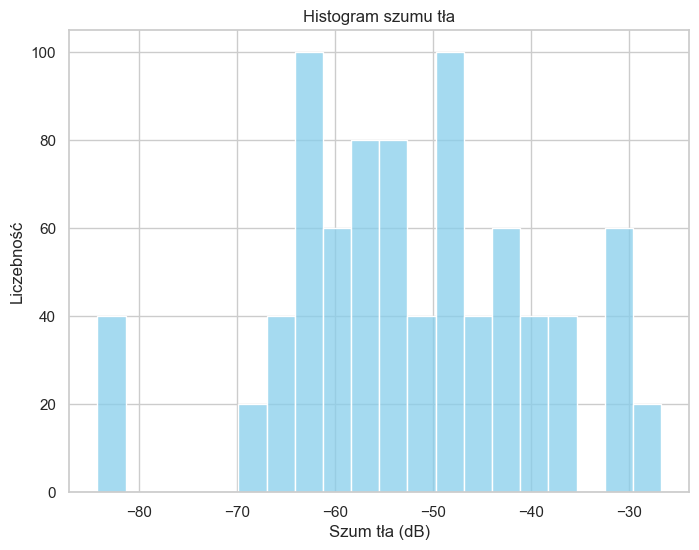

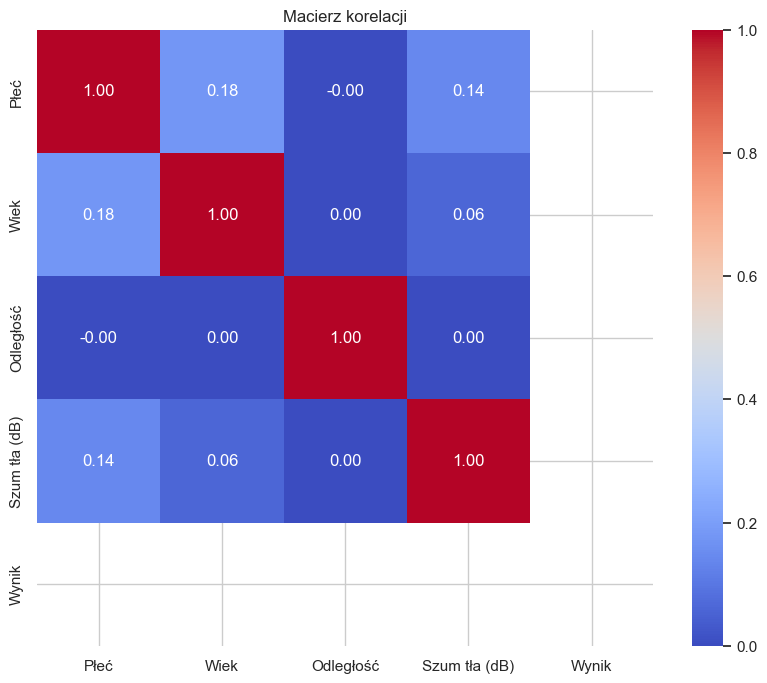

Odległość        0.5  1.0  3.0  5.0
Płeć      Wiek                     
kobieta   <18      0    0    0    0
          18-30    0    0    0    0
          31-50    0    0    0    0
          50+      0    0    0    0
mężczyzna <18      0    0    0    0
          18-30    0    0    0    0
          31-50    0    0    0    0
          50+      0    0    0    0

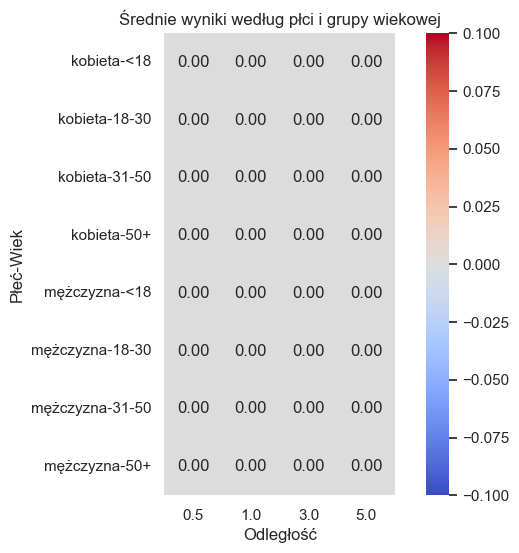

In [17]:
model_final = create_model(MODEL_PATH) #FINAL_PATH)
process_recordings(ALL_RECORDINGS_PATH, model_final)